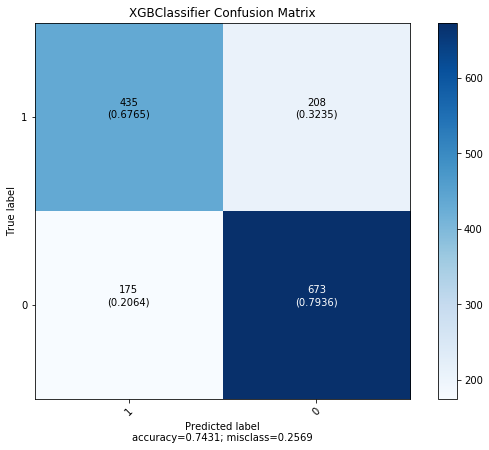

average_precision_score = 0.792
precision_score = 0.713
recall_score = 0.677
roc_auc_score = 0.735
    Importance Feature
0       0.2033      f2
1       0.1463      f1
2       0.1415      f4
3       0.1089      f8
4       0.1041      f7
5       0.0797      f3
6       0.0715     f13
7       0.0455      f6
8       0.0309      f5
9       0.0244     f12
10      0.0195     f11
11      0.0130      f9
12      0.0114     f10


In [1]:
# %%writefile train.py
# Import Packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from pre_ml_process import pre_ml_process
import pickle
from plot_confusion_matrix import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, average_precision_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

# location of training data
# training_data_loc = input("Please input the training data dir:") 
training_data_loc = "../dataset.csv"

# Import Data
df_raw = pd.read_csv(training_data_loc, encoding="cp1252")

# Data cleaning
df = df_raw.dropna()
df = df.loc[df["f7"] != "#"]
df["f7"] = df["f7"].astype(float)

# f9 - remove the unknown record and binary encode the remaining two classes
df = df.loc[df["f9"] != "unknown"]
le_f9 = LabelEncoder()
df["f9"] = le_f9.fit_transform(df["f9"])

# isolate the numerical columns
numerical_cols = df.dtypes[df.dtypes != object].index.tolist()
df_num = df[numerical_cols]

# drop employee id primary key
df_num = df_num.drop("employee_id", axis=1)

# label encode string columns
def fit_label_encoders(df_in):
    fitted_label_encoders = {}
    for col in df_in.dtypes[df_in.dtypes == object].index.tolist():
        fitted_label_encoders[col] = LabelEncoder().fit(df_in[col])
    return fitted_label_encoders

fitted_label_encoders = fit_label_encoders(df.drop("employee_id", axis=1))

# concat the label encoded dataframe with the baseline dataframe 
def add_label_encoded(df_baseline, df_to_le, cols, fitted_label_encoders):
    df_out = df_baseline.copy()
    for col in cols:
        df_le = fitted_label_encoders[col].transform(df_to_le[col])
        df_out[col] = df_le
    return df_out

df_num_allLE = add_label_encoded(df_num, df, ["f1", "f2", "f3", "f4", "f10", "f12"], fitted_label_encoders)


XGC=xgb.XGBClassifier(random_state=0, n_estimators=100) 

# parameters
split_random_state=42
xgb_fit_eval_metric="aucpr"
train_test_split_random_state=0
RandomOverSampler_random_state=0
test_size=0.33

# preprocessing
df_ignore, X, y, X_train, X_test, y_train, y_test, \
                scaler, X_train_resample_scaled, y_train_resample, \
                X_test_scaled, ros, poly_ignore = \
                pre_ml_process(df_num_allLE, 
                               test_size,
                               train_test_split_random_state,
                               RandomOverSampler_random_state)

# save scaler to file
pickle.dump(scaler, open("scaler.p", "wb"))

# Train with XGBoost Classifier
clf_XG = XGC.fit(X_train_resample_scaled, y_train_resample, eval_metric=xgb_fit_eval_metric)

# Model evaluation:

# Get test set predictions
y_test_hat = clf_XG.predict(X_test_scaled)
y_test_proba = clf_XG.predict_proba(X_test_scaled)[:,1]

# Confusion Matrix
df_cm = confusion_matrix(y_test, y_test_hat, labels=[1, 0])
plot_confusion_matrix(df_cm, 
                      target_names=[1, 0], 
                      title="%s Confusion Matrix" % (type(clf_XG).__name__),
                      normalize=True)
plt.show()

# Accuracy metrics
ap = average_precision_score(y_test, y_test_proba)
ps = precision_score(y_test, y_test_hat)
rs = recall_score(y_test, y_test_hat)
roc = roc_auc_score(y_test, y_test_hat)

print("average_precision_score = {:.3f}".format(ap))
print("precision_score = {:.3f}".format(ps))
print("recall_score = {:.3f}".format(rs))
print("roc_auc_score = {:.3f}".format(roc))

# Feature Importances
df_feature_importances = pd.DataFrame(clf_XG.feature_importances_, columns=["Importance"])
col_names = df_num_allLE.columns.tolist()
col_names.remove("has_left")
df_feature_importances["Feature"] = col_names
df_feature_importances.sort_values("Importance", ascending=False, inplace=True)
df_feature_importances = df_feature_importances.round(4)
df_feature_importances = df_feature_importances.reset_index(drop=True)
print(df_feature_importances)

# export trained model
pickle.dump(clf_XG, open("xgb_model.p", "wb"))

In [9]:
def plot_confusion_matrix2(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(8, 6),
                          include_accuracy=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot.
    
    ** I added an update to normalize=True to also plot the raw numbers **

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions **and raw numbers**

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:,}\n({:0.4f})".format(cm[i, j], cm_n[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    if include_accuracy:
        plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    else:
        plt.xlabel('Predicted label')
    plt.show()


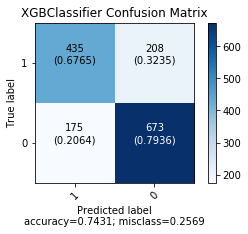

In [11]:
plot_confusion_matrix2(df_cm, 
                      target_names=[1, 0], 
                      title="%s Confusion Matrix" % (type(clf_XG).__name__),
                      normalize=True,
                      figsize=(4,3),
                      include_accuracy=True)

In [6]:
df_cm

array([[435, 208],
       [175, 673]], dtype=int64)

Please input the trained model dir: xgb_model.p
Please input the testing data dir: ../dataset.csv


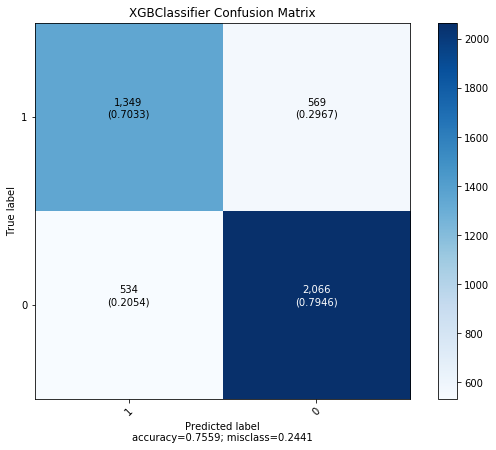

average_precision_score = 0.810
precision_score = 0.716
recall_score = 0.703
roc_auc_score = 0.749
    Importance Feature
0       0.2033      f2
1       0.1463      f1
2       0.1415      f4
3       0.1089      f8
4       0.1041      f7
5       0.0797      f3
6       0.0715     f13
7       0.0455      f6
8       0.0309      f5
9       0.0244     f12
10      0.0195     f11
11      0.0130      f9
12      0.0114     f10


In [6]:
# %%writefile test.py
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, average_precision_score, precision_score, recall_score, roc_auc_score
import xgboost as xgb
from sklearn.decomposition import PCA
from pre_ml_process import pre_ml_process
from plot_confusion_matrix import plot_confusion_matrix
import pickle

# model location
model_loc = input("Please input the trained model dir:") 
# model_loc = "xgb_model.p"

# Import trained model
clf = pickle.load(open(model_loc, "rb"))
# ../dataset.csv

# Import Data
df_raw_loc = input("Please input the testing data dir:") 
df_raw = pd.read_csv(df_raw_loc, encoding="cp1252")

# Data cleaning
df = df_raw.dropna()
df = df.loc[df["f7"] != "#"]
df["f7"] = df["f7"].astype(float)

# f9 - remove the unknown record and binary encode the remaining two classes
df = df.loc[df["f9"] != "unknown"]
le_f9 = LabelEncoder()
df["f9"] = le_f9.fit_transform(df["f9"])

# isolate the numerical columns
numerical_cols = df.dtypes[df.dtypes != object].index.tolist()
df_num = df[numerical_cols]

# drop employee id primary key
df_num = df_num.drop("employee_id", axis=1)

# label encode string columns
def fit_label_encoders(df_in):
    fitted_label_encoders = {}
    for col in df_in.dtypes[df_in.dtypes == object].index.tolist():
        fitted_label_encoders[col] = LabelEncoder().fit(df_in[col])
    return fitted_label_encoders

fitted_label_encoders = fit_label_encoders(df.drop("employee_id", axis=1))

# concat the label encoded dataframe with the baseline dataframe 
def add_label_encoded(df_baseline, df_to_le, cols, fitted_label_encoders):
    df_out = df_baseline.copy()
    for col in cols:
        df_le = fitted_label_encoders[col].transform(df_to_le[col])
        df_out[col] = df_le
    return df_out

df_num_allLE = add_label_encoded(df_num, df, ["f1", "f2", "f3", "f4", "f10", "f12"], fitted_label_encoders)

# Separate X and y
y_col = "has_left"
y = df_num_allLE[y_col]
X = df_num_allLE.drop(y_col, axis=1)
X = X.astype(float)

# Scale predictors 
scaler = pickle.load(open("scaler.p", "rb"))
X_scaled = scaler.transform(X)

# Get predictions
y_hat = clf.predict(X_scaled)
y_proba = clf.predict_proba(X_scaled)[:,1]

# Confusion Matrix
df_cm = confusion_matrix(y, y_hat, labels=[1, 0])
plot_confusion_matrix(df_cm, 
                      target_names=[1, 0], 
                      title="%s Confusion Matrix" % (type(clf).__name__),
                      normalize=True)

# accuracy metrics
ap = average_precision_score(y, y_proba)
ps = precision_score(y, y_hat)
rs = recall_score(y, y_hat)
roc = roc_auc_score(y, y_hat)

print("average_precision_score = {:.3f}".format(ap))
print("precision_score = {:.3f}".format(ps))
print("recall_score = {:.3f}".format(rs))
print("roc_auc_score = {:.3f}".format(roc))

# Feature Importances
df_feature_importances = pd.DataFrame(clf.feature_importances_, columns=["Importance"])
col_names = df_num_allLE.columns.tolist()
col_names.remove("has_left")
df_feature_importances["Feature"] = col_names
df_feature_importances.sort_values("Importance", ascending=False, inplace=True)
df_feature_importances = df_feature_importances.round(4)
df_feature_importances = df_feature_importances.reset_index(drop=True)
print(df_feature_importances)

# concat test data with predictions
df_in_with_predictions = pd.concat([df_num_allLE, pd.Series(y_hat, name="y_hat"), pd.Series(y_proba, name="y_hat_probability")], axis=1)

# Export predictions
df_in_with_predictions.to_csv("predictions_export.csv", index=False)
